In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Section 1: Data Loading and Missing Value Checks

Missing Values:
job           39
marital       11
education    167
default      803
housing      105
loan         105
dtype: int64

Percentage of Missing Values:
job           0.946832
marital       0.267055
education     4.054382
default      19.495023
housing       2.549162
loan          2.549162
dtype: float64


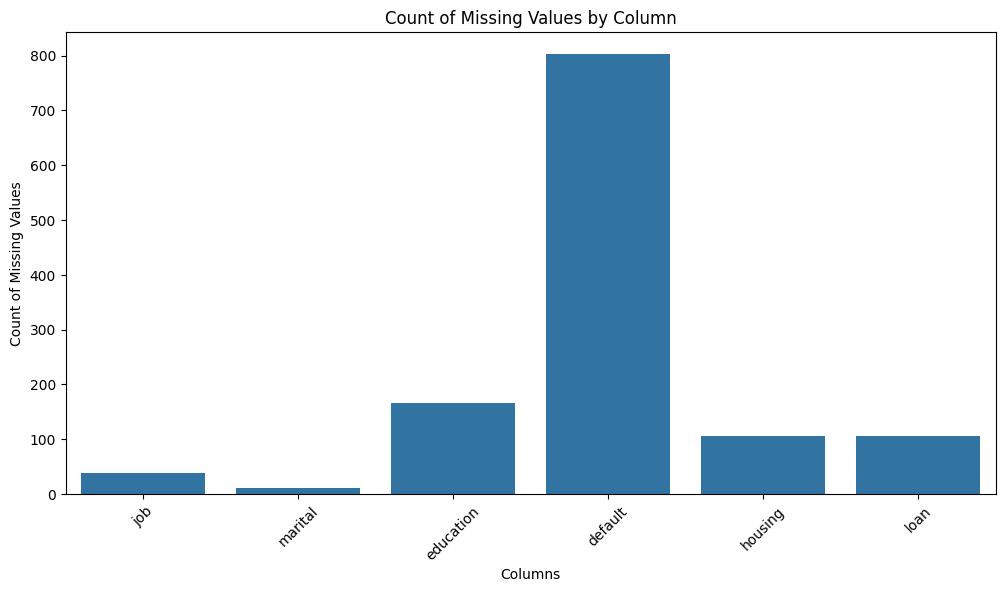

In [2]:
def load_data(file_path):
    return pd.read_csv(file_path, sep=';')

# Function to check for missing values
def check_missing_values(data):
    missing_values = data.isin(['unknown']).sum()
    missing_values = missing_values[missing_values > 0]
    print("Missing Values:")
    print(missing_values)
    return data, missing_values

# Function to calculate percentage of missing values
def calculate_missing_percentage(data_missing):
    data, missing_values = data_missing
    missing_percentage = (missing_values / len(data)) * 100
    print("\nPercentage of Missing Values:")
    print(missing_percentage)
    return data, missing_values, missing_percentage

# Function to visualize missing values
def visualize_missing_values(data_missing_percentage):
    data, missing_values, missing_percentage = data_missing_percentage
    plt.figure(figsize=(12, 6))
    sns.barplot(x=missing_values.index, y=missing_values.values)
    plt.title('Count of Missing Values by Column')
    plt.ylabel('Count of Missing Values')
    plt.xlabel('Columns')
    plt.xticks(rotation=45)
    plt.show()
    return data

# Create pipeline
pipeline = Pipeline([
    ('load_data', FunctionTransformer(lambda _: load_data('dataset/bank-additional.csv'), validate=False)),
    ('check_missing_values', FunctionTransformer(check_missing_values, validate=False)),
    ('calculate_missing_percentage', FunctionTransformer(calculate_missing_percentage, validate=False)),
    ('visualize_missing_values', FunctionTransformer(visualize_missing_values, validate=False))
])

data = pipeline.fit_transform(None)

# Section 1.1: Missing Value Analysis

Missing Values:
job           39
marital       11
education    167
default      803
housing      105
loan         105
dtype: int64
job (missing: 39)
Proportion of 'yes' for missing vs non-missing:
Missing: 10.26%
Non-missing: 10.96%
Difference in proportion: -0.70%

marital (missing: 11)
Proportion of 'yes' for missing vs non-missing:
Missing: 9.09%
Non-missing: 10.95%
Difference in proportion: -1.86%

education (missing: 167)
Proportion of 'yes' for missing vs non-missing:
Missing: 15.57%
Non-missing: 10.75%
Difference in proportion: 4.81%

default (missing: 803)
Proportion of 'yes' for missing vs non-missing:
Missing: 6.10%
Non-missing: 12.12%
Difference in proportion: -6.02%

housing (missing: 105)
Proportion of 'yes' for missing vs non-missing:
Missing: 8.57%
Non-missing: 11.01%
Difference in proportion: -2.44%

loan (missing: 105)
Proportion of 'yes' for missing vs non-missing:
Missing: 8.57%
Non-missing: 11.01%
Difference in proportion: -2.44%



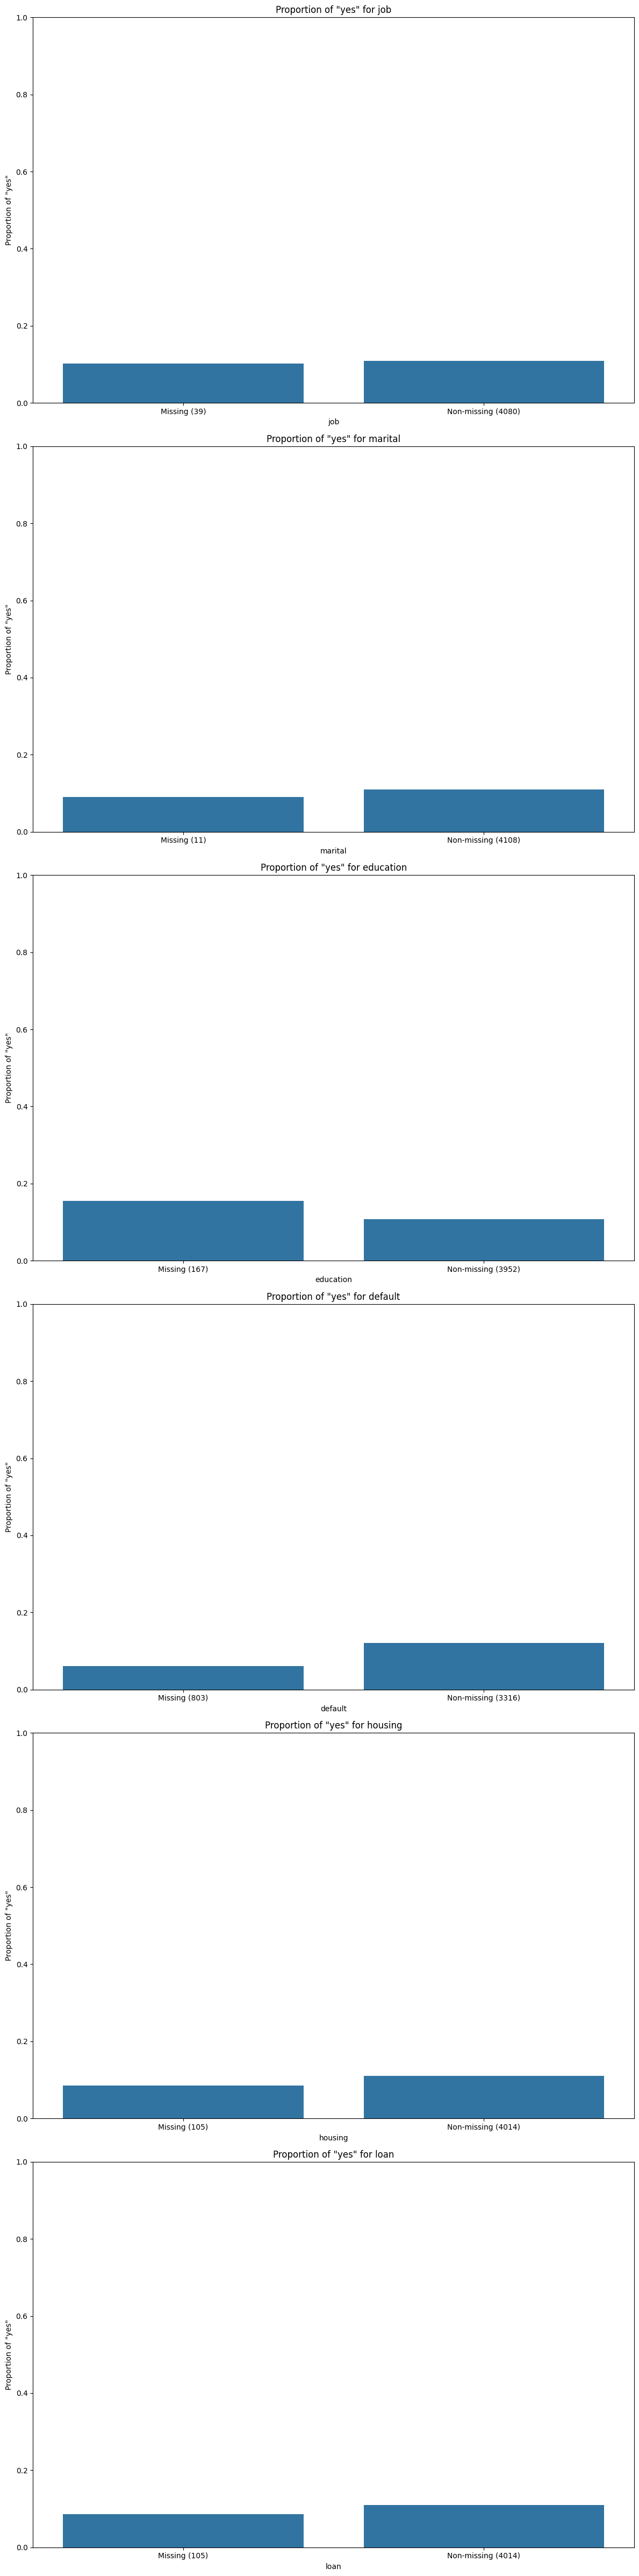

In [3]:
# Function to drop the 'duration' column because it is not known before a call is performed
def drop_duration(data):
    return data.drop('duration', axis=1)

# Function to convert 'yes'/'no' target to binary
def convert_target(data):
    data['y'] = data['y'].map({'yes': 1, 'no': 0})
    return data

# Function to analyze missing values's impact and visualize
def analyze_missing_values(data, missing_values):
    fig, axes = plt.subplots(nrows=len(missing_values.index), ncols=1, figsize=(12, 8 * len(missing_values.index)))

    for ax, col in zip(axes, missing_values.index):
        missing_mask = data[col] == 'unknown'
        total_missing = missing_mask.sum()
        total_non_missing = len(data) - total_missing

        print(f"{col} (missing: {total_missing})")
        proportion = data.groupby(missing_mask)['y'].mean()
        print("Proportion of 'yes' for missing vs non-missing:")
        print(f"Missing: {proportion[True]:.2%}")
        print(f"Non-missing: {proportion[False]:.2%}")

        # Calculate percentage difference
        diff_percentage = (proportion[True] - proportion[False]) * 100
        print(f"Difference in proportion: {diff_percentage:.2f}%")
        print()

        # Visualization with seaborn this time not with the matplotlib bcs yuksel hates it
        sns.barplot(x=[f'Missing ({total_missing})', f'Non-missing ({total_non_missing})'], 
                    y=[proportion[True], proportion[False]], ax=ax)
        ax.set_title(f'Proportion of "yes" for {col}')
        ax.set_ylabel('Proportion of "yes"')
        ax.set_xlabel(col)
        ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()
    return data

# Extract missing values
_, missing_values = check_missing_values(data)

# Create a pipeline
pipeline = Pipeline([
    ('drop_duration', FunctionTransformer(drop_duration)),
    ('convert_target', FunctionTransformer(convert_target)),
    ('analyze_missing_values', FunctionTransformer(analyze_missing_values, kw_args={'missing_values': missing_values}))
])

data = pipeline.fit_transform(data)


| **Column**   | **Missing Count** | **Difference in Proportion of 'Yes'** | **Decision**                                                                                                                                          |
|---------------|-------------------|---------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------|
| **job**       | 39               | -0.70%                                | The small difference suggests minimal bias. Imputed missing values with the mode (`most frequent value`).                                                  |
| **marital**   | 11               | -1.86%                                | The difference is small but notable. Imputed missing values with the mode, as the missing rate and impact are low.                                         |
| **education** | 167              | +4.81%                                | Missing values appear to show higher success rates. "unknown" will be encoded as a separate category to capture this distinction.                      |
| **default**   | 803              | -6.02%                                | The larger difference and high missing rate suggest that encoding "unknown" as a separate category might better capture its relationship to the target.   |
| **housing**   | 105              | -2.44%                                | The moderate difference suggests some potential bias. However after further testing with the full dataset (where the proportion is -%0.47), this bias appears to be a result of the random %10 selected more so than the actual impact of the class. Imputed missing values with the mode. |
| **loan**      | 105              | -2.44%                                | Similar situation to **housing** with a proportion of -%0.47, imputed with the mode. *The similarity with housing has been noted for future reference*|




# Final Encoding Decisions and Reasons

| **Variable**     | **Encoding Decision**     | **Reason**                                                                 |
|------------------|---------------------------|---------------------------------------------------------------------------|
| **job**          | One-hot encoding           | "job" is a nominal categorical variable with distinct types; one-hot encoding prevents introducing any ordinal relationships. |
| **marital**      | One-hot encoding           | "marital" is a categorical variable with distinct values and no natural order. One-hot encoding handles it appropriately. |
| **education**    | One-hot encoding           | "education" includes "unknown" as its own category; one-hot encoding treats each category (including `unknown`) as a separate binary column. |
| **default**      | One-hot encoding           | "default" is a binary categorical variable with "no" and "yes" values and additionally includes "unknown" as its own category, so one-hot encoding is appropriate. |
| **housing**      | One-hot encoding           | "housing" is a binary categorical variable with "no" and "yes" values, and one-hot encoding works well here. |
| **loan**         | One-hot encoding           | "loan" is also binary, with "no" and "yes" values, and one-hot encoding is suitable. |
| **contact**      | One-hot encoding           | "contact" is a nominal categorical variable with distinct types ("cellular", "telephone"), making one-hot encoding ideal. |
| **month**        | Cyclical encoding (sin/cos) | "month" is cyclical (e.g., December follows January), so sine and cosine transformations capture its cyclical nature. The complete lack of January and February, alongside the rarity of December has been noted.  |
| **day_of_week**  | One-hot encoding           | "day_of_week" is a nominal categorical variable with distinct values (days of the week) and no inherent order, so one-hot encoding is suitable. The lack of inherent order is due to the nature of this variable relating to many different weeks as opposed to a one week period. |
| **poutcome**     | One-hot encoding           | "poutcome" is categorical with distinct values (e.g., "failure", "success"), and one-hot encoding captures the separate categories. |



In [4]:
def encode_month_sin_cos(X):
    month_map = {'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
                 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
    months = X["month"]  
    months = months.map(month_map).fillna(0)  
    month_sin = np.sin(2 * np.pi * months / 12)
    month_cos = np.cos(2 * np.pi * months / 12)
    return pd.DataFrame({"month_sin": month_sin, "month_cos": month_cos})

def month_feature_names_out(self, input_features): #this took way too long to figure out jesus christ
    return ["month_sin", "month_cos"]

In [5]:
categorical_impute_cols = ['job', 'marital', 'housing', 'loan']
categorical_pass_cols = ['education', 'default']

onehot_cols = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 
               'day_of_week', 'poutcome', 'education']
numerical_cols = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
                  'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

# TODO for much later, pdays is one stupid column
# it has 999 as a value which is a placeholder for never contacted, this might be 
# a problem for the model, if so we need to handle this, but first testing the model
#  without handling it

In [6]:
mode_imputer = SimpleImputer(strategy='most_frequent', missing_values='unknown')
month_transformer = FunctionTransformer(encode_month_sin_cos, validate=False, feature_names_out=month_feature_names_out)
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

#Impute
data[categorical_impute_cols] = mode_imputer.fit_transform(data[categorical_impute_cols])

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('month_encoding', month_transformer, ['month']), 
        ('onehot', onehot_encoder, onehot_cols),
        ('scaling', scaler, numerical_cols)
    ],
    remainder='passthrough',  # Keeps other columns as is, keeping response variable, annoying cascading side effect, the y variable is renamed to remainder__y
)


transformed_data = preprocessor.fit_transform(data)
transformed_df = pd.DataFrame(transformed_data, columns=preprocessor.get_feature_names_out())


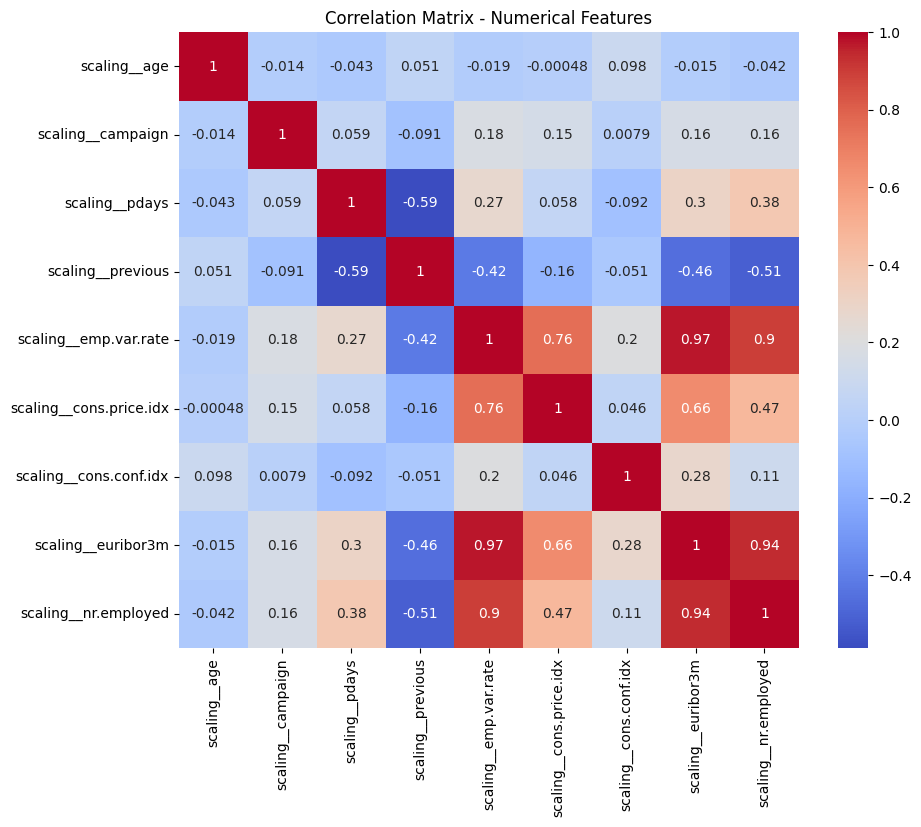

In [ ]:
# Column names with prefixes
numerical_cols_prefixed = [f'scaling__{col}' for col in numerical_cols]

numerical_corr = transformed_df[numerical_cols_prefixed].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix - Numerical Features")
plt.show()


#Intended to drop highly correlated features for some reason it lowers the f1 score
#transformed_df = transformed_df.drop(columns=['scaling__euribor3m', 'scaling__emp.var.rate'])

In [9]:
target_corr = transformed_df[numerical_cols_prefixed + ['remainder__y']].corr()['remainder__y'].drop('remainder__y')
print(target_corr.sort_values(ascending=False))


scaling__previous          0.255697
scaling__age               0.060374
scaling__cons.conf.idx     0.054393
scaling__campaign         -0.076091
scaling__cons.price.idx   -0.098326
scaling__emp.var.rate     -0.283216
scaling__euribor3m        -0.298565
scaling__pdays            -0.332012
scaling__nr.employed      -0.349241
Name: remainder__y, dtype: float64


not much to do here, no value is too low

In [10]:
# Update onehot_cols with prefixed column names
onehot_cols_prefixed = [col for col in transformed_df.columns if col.startswith('onehot__')]

#TODO experiment with different thresholds instead of 0.01
low_variance_cols = [col for col in onehot_cols_prefixed if transformed_df[col].var() < 0.01]
print("Low variance columns:", low_variance_cols)


Low variance columns: ['onehot__default_yes', 'onehot__education_illiterate']


In [11]:
from scipy.stats import pointbiserialr

for col in onehot_cols_prefixed:
    corr, _ = pointbiserialr(transformed_df[col], transformed_df['remainder__y'])
    print(f"Correlation between {col} and y: {corr}")

#TODO print better, check for very low correlation to possibly remove some columns

Correlation between onehot__job_admin. and y: 0.039098977408523194
Correlation between onehot__job_blue-collar and y: -0.06778052478502802
Correlation between onehot__job_entrepreneur and y: -0.0342753237604129
Correlation between onehot__job_housemaid and y: -0.00503561058080846
Correlation between onehot__job_management and y: -0.01581401864274161
Correlation between onehot__job_retired and y: 0.07837322465755803
Correlation between onehot__job_self-employed and y: -0.01779567975699611
Correlation between onehot__job_services and y: -0.02125292002444
Correlation between onehot__job_student and y: 0.05578146710806632
Correlation between onehot__job_technician and y: 0.009031936168411792
Correlation between onehot__job_unemployed and y: 0.032871598827602856
Correlation between onehot__marital_divorced and y: -0.014596706292201018
Correlation between onehot__marital_married and y: -0.03656826546124203
Correlation between onehot__marital_single and y: 0.04979693018799221
Correlation betw

Correlation between onehot__day_of_week_tue and y: -0.002089412357741579
Correlation between onehot__day_of_week_wed and y: -0.007971985231242543
Correlation between onehot__poutcome_failure and y: 0.04292675117446594
Correlation between onehot__poutcome_nonexistent and y: -0.20717890597444846
Correlation between onehot__poutcome_success and y: 0.32580371594795665
Correlation between onehot__education_basic.4y and y: -0.022837678052972446
Correlation between onehot__education_basic.6y and y: -0.027079401953145225
Correlation between onehot__education_basic.9y and y: -0.04456130969493903
Correlation between onehot__education_high.school and y: -0.007170576316297212
Correlation between onehot__education_illiterate and y: -0.005464248431778349
Correlation between onehot__education_professional.course and y: 0.014851210384986411
Correlation between onehot__education_university.degree and y: 0.044845213665306735
Correlation between onehot__education_unknown and y: 0.030411879148302755


In [12]:
X = transformed_df.drop(columns=['remainder__y'])
y = transformed_df['remainder__y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:

# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(random_state=42, max_depth=20, min_samples_split=10, n_estimators=300, n_jobs=-1, class_weight='balanced') 
#njobs for mutlithreading, class_weight for imbalanced classes which really helps f1 score
rf.fit(X_train, y_train)

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [14]:

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))

print("Decision Tree:")
evaluate_model(dt, X_test, y_test)
    
print("\nLogistic Regression:")
evaluate_model(log_reg, X_test, y_test)

print("\nRandom Forest:")
evaluate_model(rf, X_test, y_test)


Decision Tree:
Accuracy: 0.8446601941747572
Precision: 0.2682926829268293
Recall: 0.24444444444444444
F1 Score: 0.2558139534883721

Logistic Regression:
Accuracy: 0.8992718446601942
Precision: 0.6666666666666666
Recall: 0.15555555555555556
F1 Score: 0.25225225225225223

Random Forest:
Accuracy: 0.8871359223300971
Precision: 0.4782608695652174
Recall: 0.36666666666666664
F1 Score: 0.41509433962264153


In [15]:
print(y_train.value_counts(normalize=True))


remainder__y
0.0    0.89044
1.0    0.10956
Name: proportion, dtype: float64


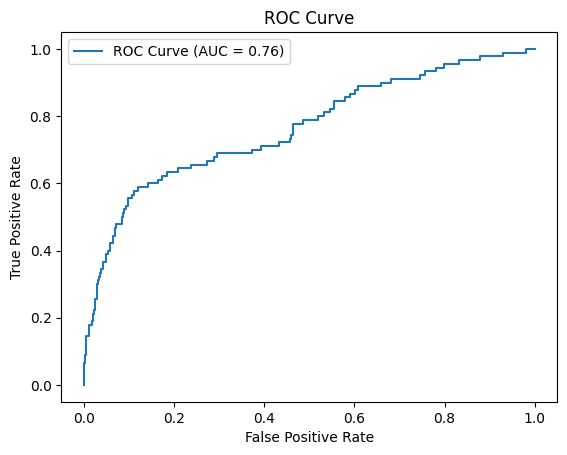

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob = rf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [None, 10, 20],
              'min_samples_split': [2, 5, 10]}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
                           param_grid, cv=5, scoring='f1') 
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)




'\nparam_grid = {\'n_estimators\': [100, 200, 300],\n              \'max_depth\': [None, 10, 20],\n              \'min_samples_split\': [2, 5, 10]}\n\ngrid_search = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1, class_weight=\'balanced\'),\n                           param_grid, cv=5, scoring=\'f1\') \ngrid_search.fit(X_train, y_train)\nprint("Best parameters:", grid_search.best_params_)\n'

In [18]:
from sklearn.metrics import precision_recall_curve

y_prob = rf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Find the threshold that maximizes F1
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = f1_scores.argmax()
optimal_threshold = thresholds[optimal_idx]

print("Optimal Threshold:", optimal_threshold)

# Predict with the new threshold
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)


'\ny_prob = rf.predict_proba(X_test)[:, 1]\nprecision, recall, thresholds = precision_recall_curve(y_test, y_prob)\n\n# Find the threshold that maximizes F1\nf1_scores = 2 * (precision * recall) / (precision + recall)\noptimal_idx = f1_scores.argmax()\noptimal_threshold = thresholds[optimal_idx]\n\nprint("Optimal Threshold:", optimal_threshold)\n\n# Predict with the new threshold\ny_pred_optimal = (y_prob >= optimal_threshold).astype(int)\n'

In [19]:
#joblib.dump(rf, 'random_forest_model.pkl')
#joblib.dump(preprocessor, 'preprocessing_pipeline.pkl')

